**Models**

**Wide Receiver**

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [10]:
all_games = pd.read_csv('nfl-football-player-stats/games_1995.csv')
all_games.drop([440917], inplace=True) # delete weird Lagerrete Blount double game
all_games.loc[all_games['team'] == 'SDG', 'team'] = 'LAC'
all_games.loc[all_games['team'] == 'STL', 'team'] = 'LAR'
all_games.loc[all_games['opponent'] == 'SDG', 'opponent'] = 'LAC'
all_games.loc[all_games['opponent'] == 'STL', 'opponent'] = 'LAR'
all_games = all_games.set_index('player_id')
all_players = pd.read_csv('nfl-football-player-stats/players_1995.csv',index_col='player_id')

In [11]:
data = pd.read_csv('wrs_2014_2017.csv', index_col='player_id')
data.head()

,year,game_number,name,team,date,log_draft_position,log_num_games,ewma_fpts,ewma_team_rush_attempts,ewma_team_rush_percentage,ewma_team_passing_rating,ewma_rushing_attempts,ewma_receiving_targets,DY/P,TO,next_fpts,fpts
player_id,,,,,,,,,,,,,,,,,
19449,2014,1,Emmanuel Sanders,DEN,2014-09-07,4.406719,4.043051,8.677391,28.862513,0.502044,111.286476,0.166838,6.293531,5.26114,2.00,14.6,11.8
7061,2014,1,Malcom Floyd,LAC,2014-09-08,5.541264,4.510860,10.243705,30.846549,0.581700,100.618927,0.000000,5.847243,4.08066,1.25,0.0,13.0
4524,2014,1,Riley Cooper,PHI,2014-09-07,5.068904,4.043051,8.774422,30.637109,0.587580,103.054470,0.000000,5.490869,5.11672,1.50,1.3,4.9
24742,2014,1,Kendall Wright,TEN,2014-09-07,2.995732,3.465736,10.476476,30.079042,0.588796,84.146077,0.008651,8.514845,5.91250,2.75,4.6,13.6
2688,2014,1,Mike Brown,JAX,2014-09-07,5.541264,2.639057,6.036812,23.762526,0.513580,76.304392,0.000000,4.877498,5.07082,3.20,0.0,5.1


In [12]:
# Tuning parameter for RF
# 400 is best
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=3)

#get 2014-2016
features = ['log_draft_position','log_num_games','ewma_fpts','ewma_team_rush_attempts','ewma_team_rush_percentage','ewma_team_passing_rating','ewma_rushing_attempts','ewma_receiving_targets','DY/P','TO']
resp = ['next_fpts']
trainX2016 = data.loc[data['year'] < 2017][features]
trainy2016 = data.loc[data['year'] < 2017][resp]

# re index
trainX2016.reset_index(drop=True, inplace=True)
trainy2016.reset_index(drop=True, inplace=True)

range_est = [250,300,350,400,450]
mses = [0,0,0,0,0]
maes = [0,0,0,0,0]

for train_index, test_index in kf.split(trainX2016):
    X_train, X_test = trainX2016.iloc[train_index], trainX2016.iloc[test_index]
    y_train, y_test = trainy2016.iloc[train_index], trainy2016.iloc[test_index]
    for j in range(len(range_est)):
        rf_model = RandomForestRegressor(n_estimators=range_est[j], random_state = 35)
        rf_model.fit(X_train, y_train)
        preds = rf_model.predict(X_test)
        mses[j] += mean_squared_error(y_test, preds)
        maes[j] += mean_absolute_error(y_test, preds)
print(mses)
print(maes)

/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarnin

[240.53932387223148, 240.22082697983342, 240.05896053470877, 239.89566810123864, 240.22625328785884]
[27.395029062851822, 27.37720374529186, 27.37635832468122, 27.366832088144626, 27.38755892124906]


1
Score:  -0.1906173685067627
MAE before feature selection:  5.457318596348154


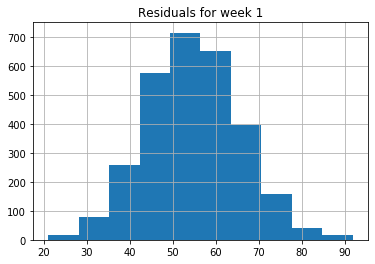

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False False False False False False]
[ 5  8  1  6 10  3  7  2  4  9]
MAE after feature selection:  5.504317694394726
2
Score:  0.22410269310810582
MAE before feature selection:  5.679330243030845


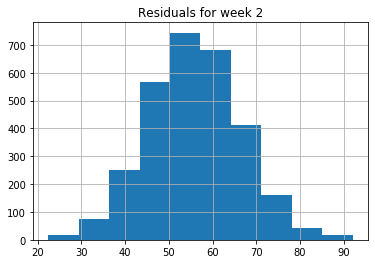

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False False False False False False]
[ 6  8  1  7 10  3  5  2  4  9]
MAE after feature selection:  5.6572956945931505
3
Score:  -0.17220764402848365
MAE before feature selection:  5.17116454623304


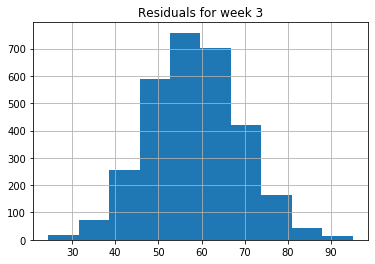

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False False False False False False]
[ 6  8  1  7  9  3  5  2  4 10]
MAE after feature selection:  5.148482276166836
4
Score:  0.24391908668701753
MAE before feature selection:  4.998274726404131


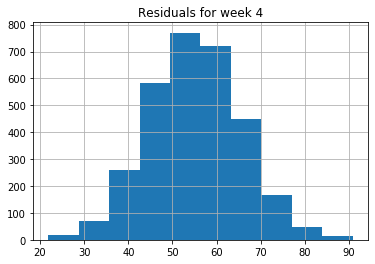

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False False False False False False]
[ 6  8  1  9  7  3  5  2  4 10]
MAE after feature selection:  5.039404968425284
5
Score:  0.2750483433042028
MAE before feature selection:  4.646994330971941


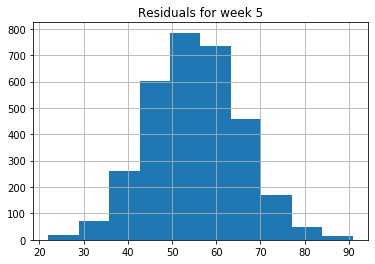

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False  True False  True False False]
[4 6 1 7 5 1 3 1 2 8]
MAE after feature selection:  4.676028393993015
6
Score:  -0.049730096250370615
MAE before feature selection:  5.020033643049366


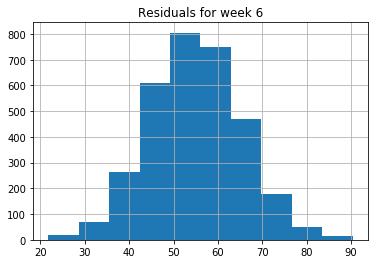

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False False False  True False False]
[4 7 1 8 6 2 5 1 3 9]
MAE after feature selection:  5.125828760898994
7
Score:  0.12041419324333646
MAE before feature selection:  5.092322199660204


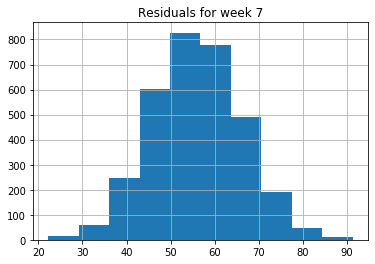

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[ True False  True False False  True False  True  True False]
[1 4 1 6 3 1 2 1 1 5]
MAE after feature selection:  5.038298534420594
8
Score:  0.1511434443871228
MAE before feature selection:  5.069551566021095


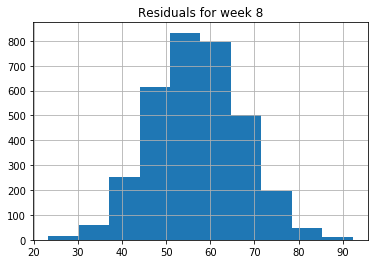

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[ True False  True False False  True  True  True  True False]
[1 3 1 5 2 1 1 1 1 4]
MAE after feature selection:  5.09088967278228
9
Score:  0.2590497326511402
MAE before feature selection:  4.854885110834987


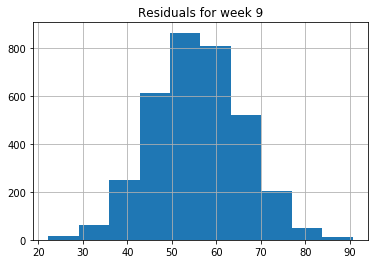

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False False False  True False False]
[4 7 1 9 6 2 5 1 3 8]
MAE after feature selection:  4.918705136582877
10
Score:  0.20987735576915623
MAE before feature selection:  5.831999553951059


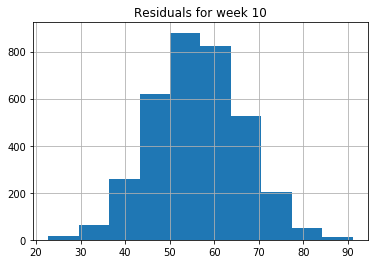

/home/s/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/s/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[False False  True False False  True False  True  True False]
[3 5 1 7 4 1 2 1 1 6]
MAE after feature selection:  5.8083609156853315


In [14]:
# Training on the 2017 season
MSEarma = []
MAEarma = []
MSElr = []
MAElr = []
MSErf = []
MAErf = []
MSEbase = []
MAEbase = []

MSElrA = []
MAElrA = []

for w in range(1,11):
    print(w)
    WEEK = w
    POSITION = 'WR'
    YEAR = 2017

    features = ['log_draft_position','log_num_games','ewma_fpts','ewma_team_rush_attempts','ewma_team_rush_percentage','ewma_team_passing_rating','ewma_rushing_attempts','ewma_receiving_targets','DY/P','TO']
    resp = ['next_fpts']
    X_train = data.loc[data['year'] < 2017][features]
    X_traincurr = data.loc[(data['year'] == 2017) & (data['game_number'] < WEEK)][features]
    if len(X_traincurr)>0:
        X_train = X_train.append(X_traincurr)
    y_train = data.loc[data['year'] < 2017][resp]
    y_traincurr = data.loc[(data['year'] == 2017) & (data['game_number'] < WEEK)][resp]
    if len(y_traincurr)>0:
        y_train = y_train.append(y_traincurr) 
    X_test = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)][features]
    y_test = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)][resp]

    # Fitting models

    # naive approach
    preds = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)]['fpts']
    MAEbase.append(mean_absolute_error(y_test, preds))
    MSEbase.append(mean_squared_error(y_test, preds))

    # ARMA
    '''
    players = get_players_thatweek(all_games, all_players, POSITION, YEAR, WEEK, subset_position)
    X, resp = get_features_response_ARMA(players, all_games, YEAR, WEEK, half_ppr)
    preds = []
    for i in resp.index:
        if type(X.loc[i]['fpts']) != np.float64:
            past_fpts = X.loc[i]['fpts'].values
            model = ARMA(past_fpts, (0,1))
            model_fit = model.fit(disp=0)
            preds.append(model_fit.forecast()[0][0])
        else:
            resp.drop([i],inplace=True)
    MAEarma.append(mean_absolute_error(resp, preds))
    MSEarma.append(mean_squared_error(resp, preds))
    '''

    # linear regression
    XtrainS = StandardScaler().fit_transform(X_train)
    XtestS = StandardScaler().fit_transform(X_test)
    XtrainT = XtrainS.copy()
    XtestT = XtestS.copy()
    lr = LinearRegression()
    lr.fit(XtrainS, y_train)
    print('Score: ',lr.score(XtestS, y_test))
    preds = lr.predict(XtestS)
    MAElr.append(mean_absolute_error(y_test, preds))
    MSElr.append(mean_squared_error(y_test, preds))
    print('MAE before feature selection: ',mean_absolute_error(y_test, preds))
    
    yhat = lr.predict(X_train)
    residuals = yhat - y_train
    plt.figure()
    plt.hist(residuals.values)
    plt.title('Residuals for week '+str(w))
    plt.grid()
    plt.show()
    
    
    selector = RFECV(lr, step=1, cv=10)
    selector = selector.fit(XtrainT, y_train)
    print(selector.support_)
    print(selector.ranking_)
    X_new = selector.transform(XtrainT)
    lr.fit(X_new,y_train)
    preds = lr.predict(selector.transform(XtestT))
    print('MAE after feature selection: ',mean_absolute_error(y_test, preds))
    MAElrA.append(mean_absolute_error(y_test, preds))
    MSElrA.append(mean_squared_error(y_test, preds))

    # random forest
    rf = RandomForestRegressor(n_estimators = 400)
    rf.fit(XtrainS, y_train)
    preds = rf.predict(XtestS)
    MAErf.append(mean_absolute_error(y_test, preds))
    MSErf.append(mean_squared_error(y_test, preds))

In [ ]:
# lr.score(XtestS, y_test)

In [15]:
print("RF: ",MAErf)
print("RF: ", MSErf)
print("LR: ",MAElr)
print("LR: ", MSElr)
print("LRAdjusted: ",MAElrA)
print("LRAdjusted: ", MSElrA)
print("baseline: ",MAEbase)
print("baseline: ", MSEbase)
print("ARMA: ",MAEarma)
print('ARMA: ', MSEarma)

RF:  [5.479271551724141, 5.869649253731343, 5.594100806451615, 5.0120492424242435, 4.463508620689654, 5.056631818181819, 5.252526315789474, 5.100080508474579, 4.914549180327872, 5.920154166666668]
RF:  [45.96152039116383, 55.130033401119405, 43.6520500372984, 37.85398131723484, 28.10834312284481, 48.89916865795451, 40.589170940789465, 47.72464756250004, 50.699754295081995, 64.08444740104169]
LR:  [5.457318596348154, 5.679330243030845, 5.17116454623304, 4.998274726404131, 4.646994330971941, 5.020033643049366, 5.092322199660204, 5.069551566021095, 4.854885110834987, 5.831999553951059]
LR:  [46.05258431315314, 51.32279467687715, 38.179595822374644, 34.90525643841751, 29.717268307940103, 46.88109878655553, 36.845408163145294, 47.15852466849845, 46.46202626961771, 65.2116311533288]
LRAdjusted:  [5.504317694394726, 5.6572956945931505, 5.148482276166836, 5.039404968425284, 4.676028393993015, 5.125828760898994, 5.038298534420594, 5.09088967278228, 4.918705136582877, 5.8083609156853315]
LRAdjus

Plot

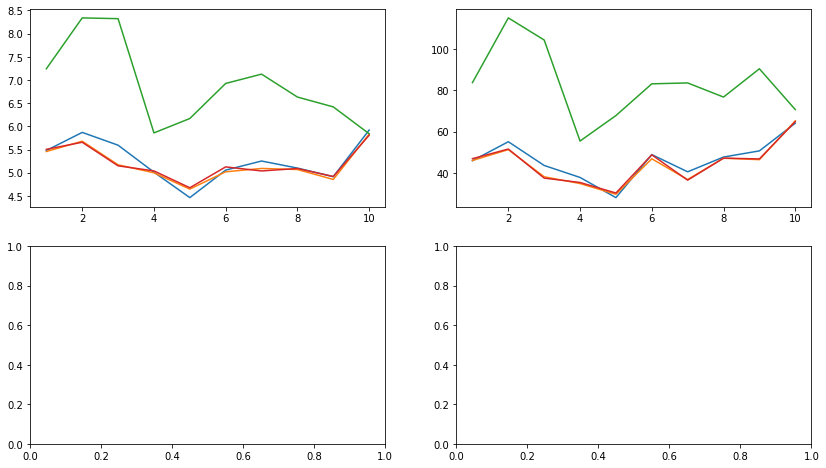

In [16]:
fig, axs = plt.subplots(2,2, figsize=(14,8))
weeks = range(1,11)
axs[0,0].plot(weeks, MAErf)
axs[0,0].plot(weeks, MAElr)
axs[0,0].plot(weeks, MAEbase)
# no need to include unless you're curious:
# axs[0,0].plot(weeks, MAElrA)
axs[0,1].plot(weeks, MSErf)
axs[0,1].plot(weeks, MSElr)
axs[0,1].plot(weeks, MSEbase)
# no need to include unless you're curious:
# axs[0,1].plot(weeks, MSElrA)

Helpful Functions

In [ ]:
def get_players_thatweek(all_games, all_players, position, year, game_number, subset_position, specific_players=None):
    if specific_players != None:
        ids = specific_players
    else:
        ids = all_players[all_players.position == position].index
        
    # return pandas df with player_id as index and player name and log draft position columns
    games = all_games.loc[ids]
    stats = subset_position[position][0]
    sum_threshold = subset_position[position][1]
    # only take RBs with 5 rush attempts or receiving targets (>= sum_threshold)
    worth_predicting = games[(games.year == year) & 
                             (games.game_number == game_number) &
                             (np.sum(games[stats], axis=1) >= sum_threshold)]
    ids = worth_predicting.index
    for_df = all_players.loc[ids, ['name', 'draft_position']]
    # players that weren't drafted give them position of last pick of draft
    for_df.fillna(255, inplace=True)
    for_df['log_draft_position'] = np.log(for_df.draft_position)
    return pd.DataFrame(data=for_df)

In [ ]:
half_ppr = {
    'rushing_yards': 0.1,
    'rushing_touchdowns': 6,
    'receiving_receptions': 0.5,
    'receiving_yards': 0.1,
    'receiving_touchdowns': 6
}

In [ ]:
# subset RB position by choosing only RBs with at least 3 fantasy points in previous game
subset_position = {
    'RB': [['rushing_attempts', 'receiving_targets'], 5.0],
    'WR': [['rushing_attempts', 'receiving_targets'], 5.0],
    'QB': [['passing_attempts'], 10.0]
}

In [ ]:
def get_features_response_ARMA(players, all_games, year, gameNumber, points_dict):
    games = all_games.loc[players.index]
    
    # compute fpts for each row
    games['fpts'] = games['game_number']*0
    for stat, value in zip(points_dict.keys(), points_dict.values()):
        games['fpts'] = games['fpts'] + games[stat]*value

    prev_years = games[(games.year < year) &
                       (games.game_number <= 16)]
    current_year = games[(games.year == year) &
                         (games.game_number <= gameNumber)]
    next_game = games[(games.year == year) &
                     (games.game_number == gameNumber+1)]
    
    df = pd.concat((prev_years, current_year))
    df.sort_values(by=['player_id', 'year', 'game_number'], axis=0,
                   ascending=False, inplace=True)
    # group dataframe by index
    df = df.groupby(df.index)
    
    past_16 = df.nth(list(range(0,16))).fpts
    weeks = df.nth(list(range(0,16))).game_number
    years = df.nth(list(range(0,16))).year
    
    # get response variable, the next game fantasy points 
    resp = next_game['fpts']

    for_return = pd.concat([past_16, years, weeks], axis=1)
    for_return.sort_values(by=['player_id', 'year', 'game_number'], axis=0, ascending=False, inplace=True)
    resp = resp.sort_index(ascending=False)
    return for_return, resp